In [1]:
# load data
import pandas as pd
music = pd.read_csv("model_ready_dataset.csv")

In [2]:
music.head(2)

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,view_count,...,avg_word_len,unique_words,vocab_richness,Rap_Street_Slang_Topic,Romance_Relationships_Topic,Life_Nostalgia_Topic,Party_Dance_Sensuality_Topic,Love_Emotion_Sentiment_Topic,Loss_Struggle_Reflection_Topic,Energy_Vibes_Epic_Topic
0,0.2020,0.759,0.699,0.000131,0.4430,-5.745,0.0307,92.960,0.907,1.118930e+09,...,4.846395,98,0.307210,0.001245,0.001247,0.001247,0.362314,0.385711,0.001244,0.246992
1,0.0393,0.535,0.505,0.000000,0.0923,-8.926,0.2450,99.935,0.495,2.205607e+08,...,5.327024,428,0.450053,0.192193,0.030384,0.000396,0.015850,0.760386,0.000396,0.000396


In [3]:
music.dtypes

acousticness                      float64
danceability                      float64
energy                            float64
instrumentalness                  float64
liveness                          float64
                                   ...   
Life_Nostalgia_Topic              float64
Party_Dance_Sensuality_Topic      float64
Love_Emotion_Sentiment_Topic      float64
Loss_Struggle_Reflection_Topic    float64
Energy_Vibes_Epic_Topic           float64
Length: 61, dtype: object

In [4]:
# Select predictors
X = music.drop(['view_count'], axis = 1)

In [5]:
X = pd.get_dummies(X,drop_first=True)
X.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,chart_year,...,avg_word_len,unique_words,vocab_richness,Rap_Street_Slang_Topic,Romance_Relationships_Topic,Life_Nostalgia_Topic,Party_Dance_Sensuality_Topic,Love_Emotion_Sentiment_Topic,Loss_Struggle_Reflection_Topic,Energy_Vibes_Epic_Topic
0,0.20200,0.759,0.699,0.000131,0.4430,-5.745,0.0307,92.960,0.907,1999,...,4.846395,98,0.307210,0.001245,0.001247,0.001247,0.362314,0.385711,0.001244,0.246992
1,0.03930,0.535,0.505,0.000000,0.0923,-8.926,0.2450,99.935,0.495,1999,...,5.327024,428,0.450053,0.192193,0.030384,0.000396,0.015850,0.760386,0.000396,0.000396
2,0.54200,0.698,0.533,0.000000,0.3330,-6.246,0.0437,134.001,0.275,1999,...,5.063918,141,0.290722,0.000765,0.418962,0.230767,0.000766,0.347208,0.000765,0.000766
3,0.00364,0.767,0.551,0.000000,0.0451,-7.328,0.0616,100.904,0.796,1999,...,4.838269,132,0.300683,0.000900,0.000902,0.000901,0.000906,0.994590,0.000900,0.000901
4,0.17500,0.398,0.804,0.000000,0.1810,-5.559,0.0451,186.752,0.709,1999,...,5.375000,117,0.365625,0.001012,0.324886,0.046997,0.624069,0.001012,0.001011,0.001014


In [6]:
X.shape

(5395, 60)

In [7]:
# select target
y=music[['view_count']]

y.head()

,view_count
0,1.118930e+09
1,2.205607e+08
2,8.756409e+07
3,1.049947e+07
4,2.109060e+07


In [15]:
# load the required library
from sklearn.model_selection import train_test_split

# split data into training (70%) and testing (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [16]:
# 1. Load libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 2. Build the model
rf = RandomForestRegressor(
    n_estimators=300, 
    random_state=1234,
    n_jobs=10  
)

# 3. Train the model
rf.fit(X_train, y_train)

# 4. Predict on the test set
y_pred = rf.predict(X_test)

# 5. Evaluate
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R²:", r2)

RMSE: 0.37075281354883216
R²: 0.15297593138522547


/opt/tljh/user/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


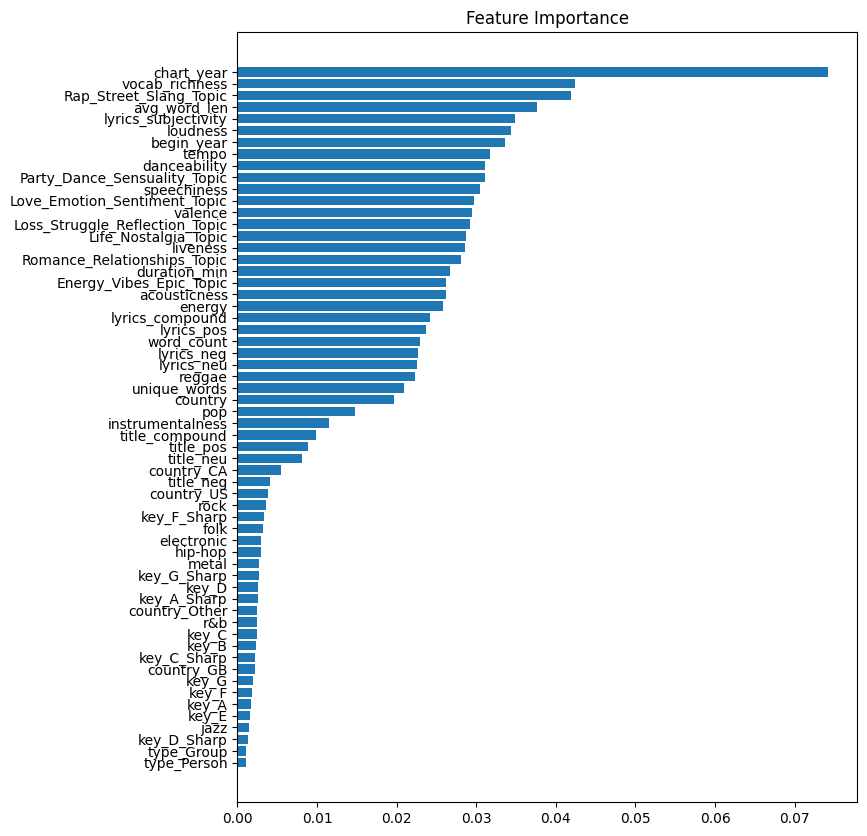

In [17]:
import matplotlib.pyplot as plt
import numpy as np

importances = rf.feature_importances_
sorted_idx = np.argsort(importances)

plt.figure(figsize=(8, 10))
plt.barh(X.columns[sorted_idx], importances[sorted_idx])
plt.title("Feature Importance")
plt.show()

In [18]:
music['view_class'] = pd.qcut(music['view_count'], 3,
                              labels=['low', 'medium', 'high'])

In [19]:
X = music.drop(columns=['view_count', 'view_class'])
y = music['view_class']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=100
)


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_auc_score

music = pd.read_csv("model_ready_dataset.csv")

music['viral'] = (music['view_count'] > 100000000).astype(int)

# Define features and target
X = music.drop(columns=["view_count", "viral"])
y = music["viral"]

categorical_cols = X.select_dtypes(include='object').columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1234
)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=300, random_state=1234, n_jobs=2)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]  # probability of being popular

# Evaluate
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)
specificity = tn / (tn + fp)
auc = roc_auc_score(y_test, y_prob)

print("\n--- Model Evaluation ---")
print("Confusion Matrix:\n", cm)
print(f"Accuracy: {accuracy:.3f}")
print(f"Sensitivity (TPR): {sensitivity:.3f}")
print(f"Specificity (TNR): {specificity:.3f}")
print(f"AUC: {auc:.3f}")




--- Model Evaluation ---
Confusion Matrix:
 [[980  65]
 [402 172]]
Accuracy: 0.712
Sensitivity (TPR): 0.300
Specificity (TNR): 0.938
AUC: 0.755


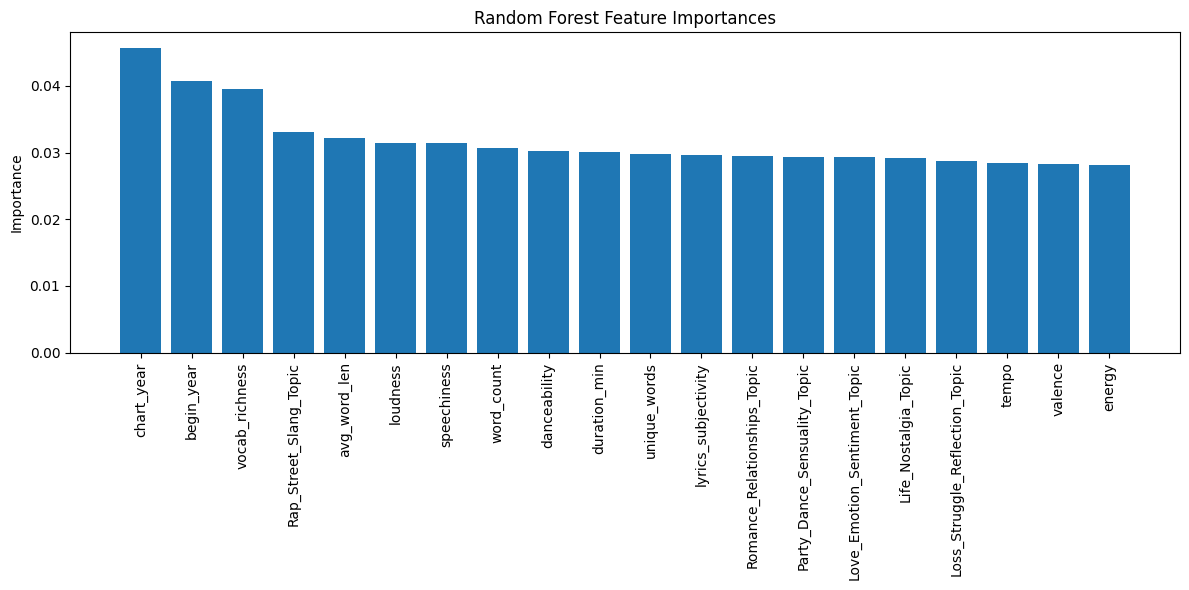

In [22]:
# Feature importance plot
importances = clf.feature_importances_
feature_names = X.columns

# Sort features by importance
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Random Forest Feature Importances")
plt.bar(range(20), importances[indices][:20], align='center')  # top 20 features
plt.xticks(range(20), [feature_names[i] for i in indices][:20], rotation=90)
plt.ylabel("Importance")
plt.tight_layout()
plt.show()